In [1]:
# Parameters
# Capacitté determiné par : qté totale d'energie dipso = un peu plus que la quantité totae d'energie pour satisfaire la demande fixée (D = 1000 kg/h par exemple)
# Problème d'optim pour determiner les capacité à installer ?
# Cout d'installation => meilleure résilience / constance de la rpoduction => obtenue avec les couts d'installation  de stockage
# capa * sum(profle) =  0.95 * Demand * Time (0.95 arbitraire, à ajuster)
wind_capa = None # Tbd as said above
solar_capa = None # Tbd as said above
wind_profile = None # Tbd from the database, depending on the year
solar_profile = None # Tbd from the database, depending on the year

# First steps, using a whole year of data (we have 3 such years)
# determination des capacités de stockage  => min de cappex + curtailment costs + imports
# Coût de l'import / curtaiilment => très hauts & constants, pour être utilisés en dernier recours 

In [2]:
from pulp import *
import matplotlib.pyplot as plt
from src.default_values import *
from load_profiles import *
from solverFixedProdStorage import solve_fixed_prod_storage

In [3]:
solver_list = listSolvers(onlyAvailable=True)
print(solver_list)

Set parameter Username
['PULP_CBC_CMD']


/home/nicolas/.local/lib/python3.11/site-packages/pulp/apis/gurobi_api.py:238: UserWarning: GUROBI error: HostID mismatch (licensed to 64a1715e, hostid is 45c2c7df).
  warnings.warn(f"GUROBI error: {e}.")
/home/nicolas/.local/lib/python3.11/site-packages/pulp/apis/gurobi_api.py:443: UserWarning: GUROBI error: Set parameter Username
Set parameter LogFile to value "gurobi.log"

Failed to set up a license

Error 10009: HostID mismatch (licensed to 64a1715e, hostid is 45c2c7df)


.
  warnings.warn(f"GUROBI error: {out}.")


In [4]:
filename = "profiles.csv"
wind_column, solar_column = "DE_wind_profile", "DE_solar_profile"
df = load_profiles(filename, [wind_column, solar_column])

In [5]:
# We keep the year 2015, 2016 and 2017 for now
years = [2015, 2016, 2017]
wind_profiles = {}
solar_profiles = {}
for year in years:
    wind_profiles[year] = df[wind_column].filter(like = str(year), axis = 0)
    solar_profiles[year] = df[solar_column].filter(like = str(year), axis = 0)

In [21]:
# We use the default values for now
D = 1000
BAT_SIZE = 400
TANK_SIZE = 500
time_index = wind_profiles[2015].index
wind_profile = wind_profiles[2015].values
solar_profile = solar_profiles[2015].values
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * len(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile)


In [22]:
output = solve_fixed_prod_storage(wind_capa, wind_profile, solar_capa, solar_profile, BAT_SIZE, TANK_SIZE, D)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicolas/.local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8fd7ef5eacc34e37bc334978641a0c73-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/8fd7ef5eacc34e37bc334978641a0c73-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 87610 COLUMNS
At line 271577 RHS
At line 359183 BOUNDS
At line 376704 ENDATA
Problem MODEL has 87605 rows, 70083 columns and 183965 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17517 (-70088) rows, 43793 (-26290) columns and 70065 (-113900) elements
Perturbing problem by 0.001% of 1000.1463 - largest nonzero change 0.00011100082 ( 1.1100082e-05%) - largest zero change 0.00011099565
0  Obj 235711.07 Primal inf 1773454.9 (17517) Dual inf 1999.9999 (2)
312  Obj 10711.076 Primal inf 1711506 (17248)
624  Obj 10711.076 Primal inf 1649106 (16936)
9

In [23]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
print(f"Storage cost: {storage_cost}, operating cost: {operating_cost}")
print(f"Total cost: {storage_cost + operating_cost}")

Storage cost: 223500.0, operating cost: 171203220.0
Total cost: 171426720.0


In [24]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["consPPA"]
print(output.keys())

dict_keys(['charge', 'prod', 'stock', 'elecGrid', 'curtail', 'consPPA', 'flowBat', 'flowH2', 'operating_cost', 'storage_cost'])


Text(0.5, 1.0, 'H2 production and stock, constant demand of 1000 Kg')

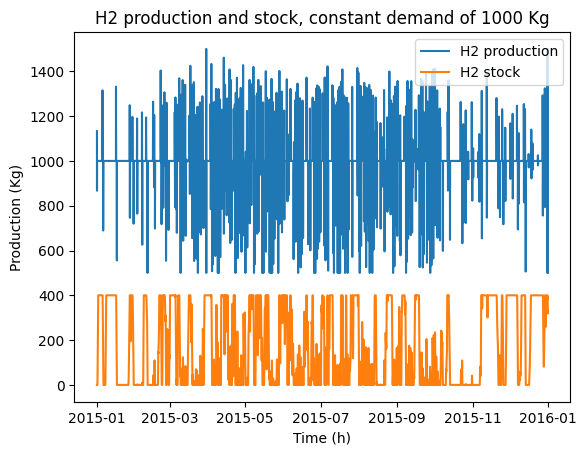

In [25]:
# Plot the production
fig, ax = plt.subplots()


ax.plot(time_index, prod_out, label = "H2 production")
ax.plot(time_index, stock_out[:-1], label = "H2 stock")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Production (Kg)")
ax.set_title(f"H2 production and stock, constant demand of {D} Kg")

Text(0.5, 1.0, 'Consumptions')

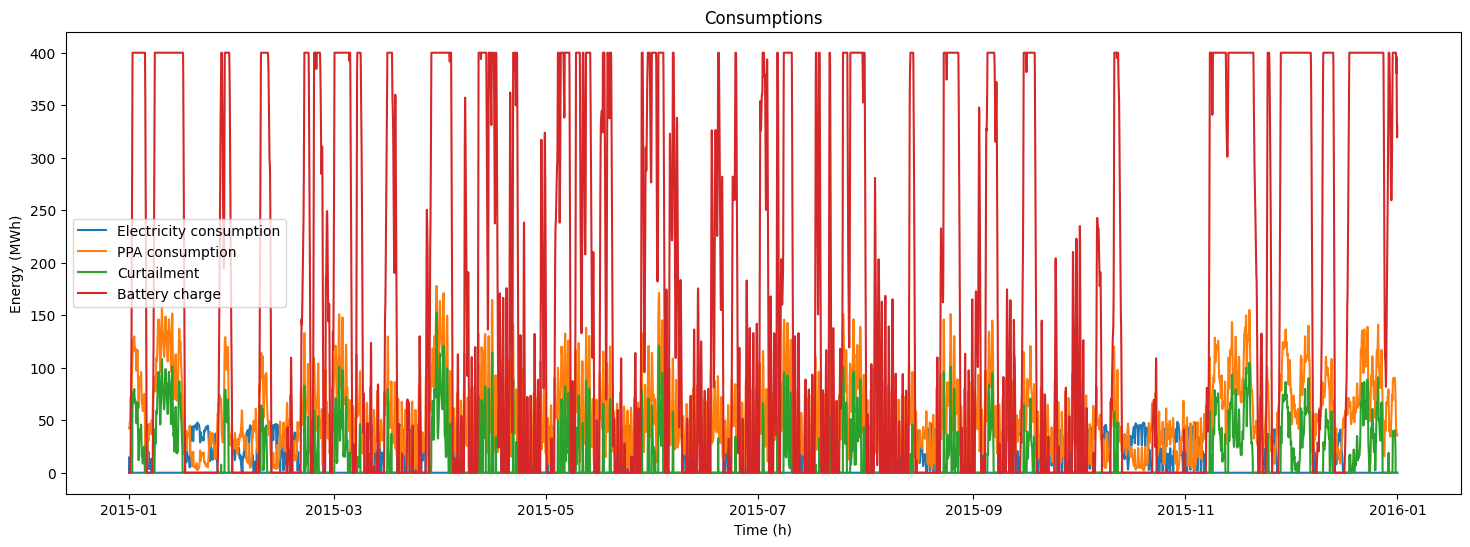

In [26]:
fig = plt.figure(figsize = (18, 6))
# Plot the consumptions
ax = fig.add_subplot(111)
ax.plot(time_index, elec_out, label="Electricity consumption")
ax.plot(time_index, consPPA_out, label="PPA consumption")
ax.plot(time_index, curtailment_out, label="Curtailment")
ax.plot(time_index, charge_out[:-1], label="Battery charge")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Energy (MWh)")
ax.set_title("Consumptions")